In [9]:
from  data_preprocessing import return_dataloaders
from computer_vision.auteencoders.models.AutoEncoder import AutoEncoder_mnist
import torch
import torch.nn as nn
import tqdm.notebook as tq
import matplotlib.pyplot as plt

In [17]:
train_dataloader, val_dataloader, test_dataloader = return_dataloaders(128, 128,8)
model = AutoEncoder_mnist()


In [18]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.MSELoss()
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.4)

In [13]:
def train(model, dataloader, criterion, opt, epoch, device=device):
  model.train()
  epoch_loss = 0.0
  for image, _ in tq.tqdm(dataloader):
    image = image.to(device)
    output = model(image)

    loss = criterion(output, image)

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_loss += loss.item() * image.size(0)
  epoch_loss = epoch_loss / len(dataloader.dataset)
  print(f'Training, Epoch : {epoch} train_loss: {epoch_loss}')
  return model

In [14]:
def test(model, dataloader, criterion, opt, epoch, device=device):
  model.eval()
  epoch_loss = 0.0
  for image, _ in tq.tqdm(dataloader):
    with torch.no_grad():
      image = image.to(device)
      output = model(image)
      loss = criterion(output, image)
      loss_loss = loss
    epoch_loss += loss.item() * image.size(0)
  epoch_loss = epoch_loss / len(dataloader.dataset)
  print(f'Testing, Epoch: {epoch} test_loss: {epoch_loss}')

In [15]:
def plot_results(model, dataloader, epoch,num_images=8):
  img, _ = next(iter(test_dataloader))
  fig = plt.figure(figsize=(13,4))
  rows = 2
  columns = 8
  for i in range(num_images):
    fig.add_subplot(rows, columns, i + 1)
    plt.imshow(img[i][0].reshape(28, 28), cmap='gist_gray')
    plt.axis('off')

    fig.add_subplot(rows, columns, i + 1 + num_images)
    inp = img[i].to(device).reshape(1, 1, 28, 28)
    out = model(inp)
    out = out.reshape(28,28).detach().cpu().numpy()
    plt.imshow(out, cmap='gist_gray')
    plt.axis('off')

  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 0 train_loss: 0.4153660498380661


  0%|          | 0/79 [00:00<?, ?it/s]

Testing, Epoch: 0 test_loss: 0.08799793212413788


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 1 train_loss: 0.10339664704799652


  0%|          | 0/79 [00:00<?, ?it/s]

Testing, Epoch: 1 test_loss: 0.056345971596240996


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 2 train_loss: 0.057088588577508925


  0%|          | 0/79 [00:00<?, ?it/s]

Testing, Epoch: 2 test_loss: 0.036959349381923676


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 3 train_loss: 0.042009099835157396


  0%|          | 0/79 [00:00<?, ?it/s]

Testing, Epoch: 3 test_loss: 0.033616598278284074


  0%|          | 0/469 [00:00<?, ?it/s]

Training, Epoch : 4 train_loss: 0.03588056692679723


  0%|          | 0/79 [00:00<?, ?it/s]

Testing, Epoch: 4 test_loss: 0.031511095815896985


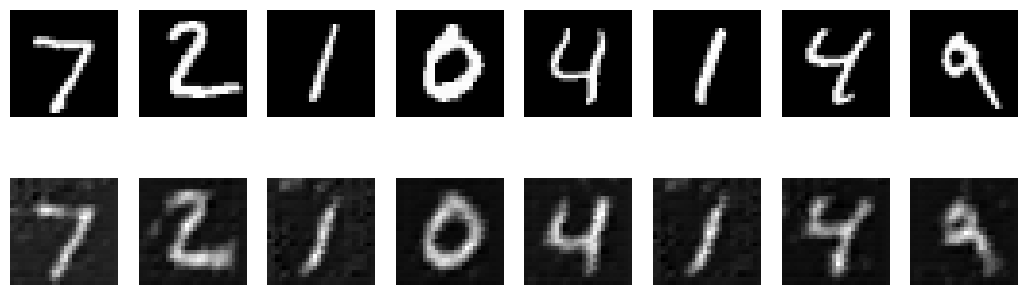

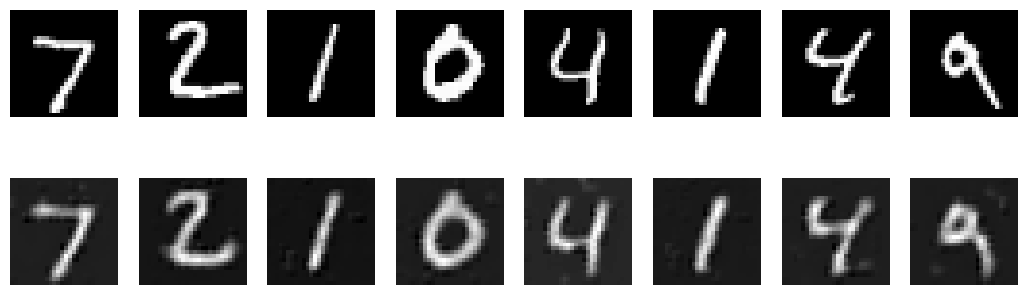

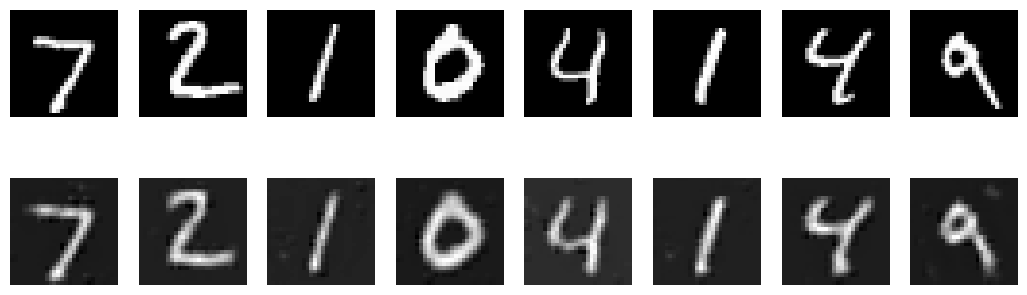

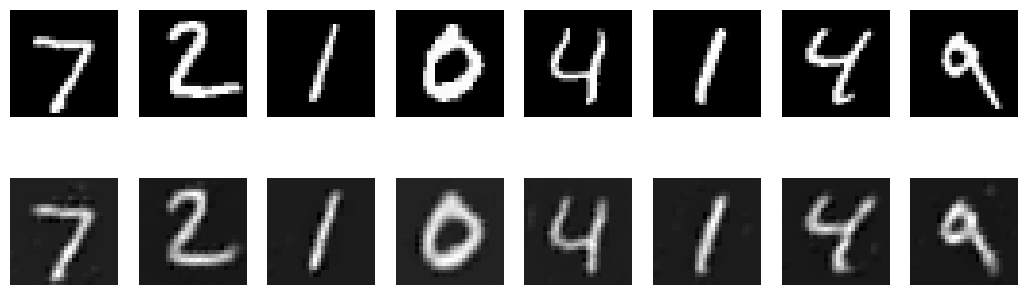

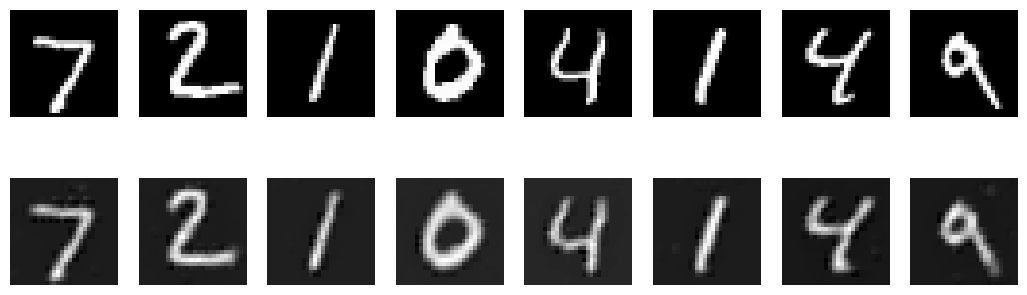

In [19]:
NUM_EPOCHS = 5
for epoch in range(NUM_EPOCHS):
  model = train(model, train_dataloader, criterion, optimizer, epoch)
  test(model, val_dataloader, criterion, optimizer, epoch)
  scheduler.step()
  plot_results(model, test_dataloader, epoch)

Trying to create new images from the features extracted from the encoder

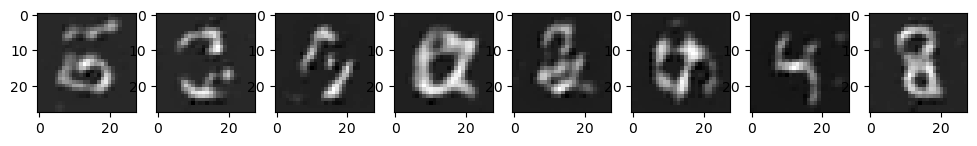

In [40]:
model.eval()
with torch.no_grad():
  images, labels = next(iter(test_dataloader))
  images = images.to(device)

  output = model.encoder(images)
  output = output.detach().cpu()

  mean = output.mean(dim=0)
  std = (output - mean).pow(2).mean(dim=0).sqrt()
  new_images = torch.randn(8, 128)*std + mean

  new_images = new_images.to(device)
  new_images = model.decoder(new_images)
  new_images = new_images.detach().cpu().numpy()

  fig = plt.figure(figsize=(12,6))
  for i in range(len(labels)):
    fig.add_subplot(1, len(labels), i+1)
    plt.imshow(new_images[i].reshape(28, 28), cmap='gist_gray')